In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.stats import skew
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [2]:
def max_tp(waveform):
    tp100 = np.argmax(waveform)
    return tp100

def tp(waveform, percent):
    tp0 = int(waveform[0])
    waveform = waveform[1:]
    tp100 = max_tp(waveform)
    tp100_val = waveform[tp100]
    tp_val = waveform[tp0] + (tp100_val * percent)
    tp = np.argmin(np.abs(waveform[tp0:] - tp_val))
    tp = tp + tp0
    return tp

def LQ80(waveform):
    tp80 = tp(waveform, .8)
    threshold = waveform[tp80]
    crossing_index = np.where(waveform >= threshold)[0][-1]
    charge_after_80 = np.sum(waveform[crossing_index:])
    return charge_after_80

def area_growth_rate(waveform):
    tp80 = tp(waveform, .8)
    threshold = waveform[tp80]
    crossing_index = np.where(waveform >= threshold)[0][0]
    window_start = crossing_index
    window_end = np.argmax(waveform)

    actual_area = np.sum(waveform[window_start:window_end+1])
    average_tail = np.linspace(waveform[window_start], waveform[window_end], window_end - window_start + 1)
    average_area = np.sum(average_tail)

    AGR = actual_area - average_area
    return AGR

def inflection_points(waveform):
    tp100 = max_tp(waveform[1:])
    tp80 = tp(waveform, .8)
    threshold = waveform[tp80]
    waveform = waveform[1:]
    crossing_index = np.where(waveform >= threshold)[0][0]
    LQ80 = waveform[crossing_index:tp100]
    if len(LQ80) < 2:
        return 0
    num = tp100 - crossing_index
    x = crossing_index + np.arange(1, num + 1)
    second = np.gradient(np.gradient(LQ80))
    #second = np.gradient(np.gradient(LQ80)) == 0
    sign_changes = np.diff(np.sign(second))
    inflection_points = np.where((sign_changes == 2) | (sign_changes == -2))[0]
    return len(inflection_points)

def window_data(waveform):
    start_index = int(row[0])       # First element is the index
    timeseries = row[1:]            # Remaining elements are the timeseries
    return timeseries[start_index:] 
#inflection_points(waveform)

In [3]:
from scipy.stats import linregress

def rising_edge_slope(waveform):
    tp0 = int(waveform[0])
    tp100 = max_tp(waveform[1:])
    
    waveform = waveform[1:]
    time = np.arange(len(waveform[tp0:tp100]))
    data = waveform[tp0:tp100]
    if len(data) == 0:
        return np.nan
    slope, intercept, r_value, p_value, std_err = linregress(time, data)
    trend_line = intercept + slope * time
    return slope

def get_tdrift50(waveform, start_idx = 1000):

    # Find the index of the peak value
    max_idx = np.argmax(waveform)

    # Calculate the middle y-value (50%) between start and max
    start_y = waveform[start_idx]
    max_y = waveform[max_idx]
    mid_y = (start_y + max_y) / 2

    # Find the x-value (index) where the waveform crosses the middle y-value
    mid_x_idx = start_idx + np.argmax(idx_waveform[start_idx:max_idx] >= mid_y)

    tdrift50 = mid_x_idx - start_idx 

    print(f" Start X value: {start_idx}\n",f"50% X value: {mid_x_idx}\n",f"tdrift50: {tdrift50}\n")

    return int(tdrift50)

def find_dcr(waveform):

    # Find peak index value
    peak_idx = np.argmax(waveform[1:])

    # Find peak value
    peak_val = int(waveform[peak_idx])

    # We are only looking at the data after the peak
    data_after_peak = waveform[peak_idx:]

    # Get all time indices between peak and end of the time series
    time_indices = np.arange(peak_idx, len(waveform))

    # Calculate DCR region
    area_above_tail_slope = np.trapezoid(peak_val - data_after_peak, x=time_indices) 
    
    return area_above_tail_slope

def normalized_fourier(waveform):
    tp0 = int(waveform[0])
    waveform = waveform[1:]
    peak = np.argmax(waveform)
    frq = np.fft.fftfreq(len(waveform[tp0:peak]), d=1)
    magnitude = np.abs(np.fft.fft(waveform[tp0:peak]))
    normalized_fft = magnitude / np.max(magnitude)
    return normalized_fft, frq

def sum_of_gaussians(frq, a1, mu1, sigma1, a2, mu2, sigma2):
    return (a1 * np.exp(-0.5 * ((frq - mu1) / sigma1) ** 2) +
            a2 * np.exp(-0.5 * ((frq - mu2) / sigma2) ** 2))

def lfpr(frq_waveform,threshold=0.05):
    power_spectrum = np.abs(frq_waveform)**2
    low_frequency_power = np.sum(power_spectrum[frq_waveform < threshold])
    return low_frequency_power / np.sum(power_spectrum)

def rsa(waveform):
    tp0 = int(waveform[0])
    waveform = waveform[1:]
    x = np.arange(waveform.shape[0])
    end = np.where(waveform == np.max(waveform))[0][0]
    interp_range = np.arange(tp0, end + 1, 1)
    interp = interpolate.interp1d(x, waveform, kind = 'linear')
    interp_vals = interp(interp_range)
    skewness = skew(interp_vals)
    return(skewness)

def tdrift(waveform, tp0):
    peak = np.argmax(waveform)
    tdrift = (peak-tp0) * 0.999
    tdrift50 = (peak-tp0) * 0.5
    tdrift10 = (peak-tp0) * 0.1
    return tdrift, tdrift50, tdrift10


def current_amplitude(waveform):
    window_size = 101  
    poly_order = 3 
    x = np.arange(len(waveform))
    interp_func = interp1d(x, waveform, kind='cubic')  
    x_interp = np.linspace(0, len(waveform) - 1, len(waveform) * 10)  
    y_interp = interp_func(x_interp)
    
    
    y_interp = y_interp / np.max(np.abs(y_interp))
    
    # Savitzky-Golay filter 
    derivative = savgol_filter(y_interp, window_size, poly_order, deriv=1)
    
    # Find the maximum current amplitude
    max_amplitude = np.max(np.abs(derivative))
    
    return max_amplitude

In [4]:
file_path = 'data/MJD_Test_1.hdf5'

In [5]:
with h5py.File(file_path, 'r') as file:
    data = np.array(file['raw_waveform'])
    tp0 = np.array(file['tp0'])
    tp0 = tp0[:, np.newaxis]
    data_LQ80 = np.hstack((tp0, data))

In [6]:
LQ80 = np.array([LQ80(x) for x in data_LQ80])
AGR = np.array([area_growth_rate(x) for x in data])
IP = np.array([inflection_points(x) for x in data_LQ80])

In [7]:
RE = np.array([rising_edge_slope(x) for x in data_LQ80])

In [8]:
rsa = np.array([rsa(x) for x in data_LQ80])  

C:\Users\rtdoh\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
C:\Users\rtdoh\anaconda3\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\rtdoh\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rtdoh\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
tp10 = np.array([tp(x, .1) for x in data_LQ80])  
tp50 = np.array([tp(x, .5) for x in data_LQ80])  
tp100 = np.array([max_tp(x) for x in data])

In [10]:
CA = np.array([current_amplitude(x) for x in data]) 

In [ ]:
fourier

In [11]:
#lfpr = np.array([lfpr(x) for x in data_LQ80])

In [10]:
fourier = []
for i in range(len(data_LQ80)):
        fourier.append(normalized_fourier(data_LQ80[i]))

In [11]:
df = pd.DataFrame({
    'LQ80': LQ80,
    'area_growth_Rate': AGR,
    'inflection_points': IP,
    'rising_edge_slope': RE,
    'rising_edge_assymetry': rsa,
    'current_amplitude': CA,
    'tp10': tp10,
    'tp50': tp50,
    'tp100': tp100
})

In [14]:
df.to_csv("first_file.csv", index=False)

for i in range(len(data_LQ80)):
    print(i)
    rising_edge_slope(data_LQ80[i])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


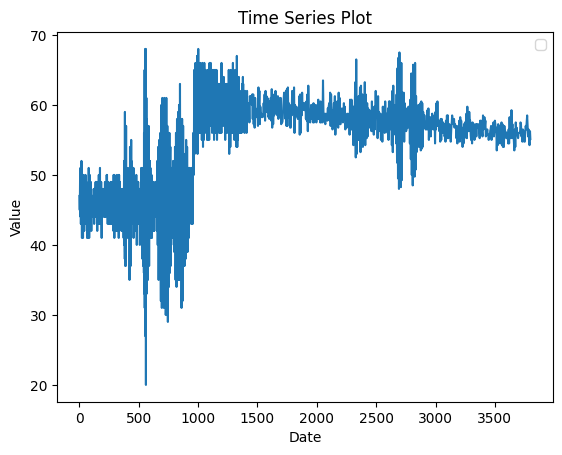

In [66]:
time = np.linspace(0, 1, len(waveform))
plt.plot(waveform)
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()